# Description - Do Spectral Power Analysis at the Segment Level (Welch Method)

This notebook will do the following operations:

* Compute the spectrograms for each identified Eyes Open (EO) and Eyes Closed (EC) segment
* Looks for statistical differences in power spectra across both types of scan segments
* Generate Panel B of figure 5

> Becuase of how fast these operations are, this time we do not rely on swarm jobs, but do all the computations as part of this notebook

Primary outputs from this notebook include:

* ```Resources/ET_Peridiograms_perSegments_EC.pkl```: Peridiograms for all EC segments lasting more than 60 seconds.
* ```Resources/ET_Peridiograms_perSegments_EO.pkl```: Peridiograms for all EO segments lasting more than 60 seconds.
* Panel B of Figure 5

***
# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os.path as osp
from utils.variables import Resources_Dir, DATA_DIR

from scipy.signal import get_window, welch
from scipy.stats  import kruskal

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

## Configuration of Scan Level PSD Analysis

In [2]:
REGION      = 'V4_grp'      # Work with Group Level FV mask
WIN_LENGTH  = 60            # Window Length for Welch Method (in seconds)
WIN_OVERLAP = 45            # Window Overlap for Welch Method (in seconds)
NFFT        = 128           # FFT Length for Welch Method (in number of samples)
SCALING     = 'density'     # Scaling method
DETREND     = 'constant'    # Type of detrending
FS          = 1             # 1/TR (in Hertzs)
NACQ        = 890           # Number of time-points

# Loadings Segment info and Segment information

In [3]:
Scan_Segments = {}
EC_Segments_Path = osp.join(Resources_Dir,'EC_Segments_Info.pkl')
EO_Segments_Path = osp.join(Resources_Dir,'EO_Segments_Info.pkl')
Scan_Segments['EC'] = pd.read_pickle(EC_Segments_Path)
Scan_Segments['EO'] = pd.read_pickle(EO_Segments_Path)

## Select only segments with duration about 60 seconds

In [4]:
Scan_Segments['EC'] = Scan_Segments['EC'][Scan_Segments['EC']['Duration']>60]
Scan_Segments['EO'] = Scan_Segments['EO'][Scan_Segments['EO']['Duration']>60]
num_EC              = Scan_Segments['EC'].shape[0]
num_EO              = Scan_Segments['EO'].shape[0]
print('++ Number of EC segments with duration > 60 seconds is %d' % num_EC)
print('++ Number of EO segments with duration > 60 seconds is %d' % num_EO)

++ Number of EC segments with duration > 60 seconds is 234
++ Number of EO segments with duration > 60 seconds is 755


***
## Compute Peridiograms (via Welch method) on a segment-per-segment basis

In [5]:
%%time
## Load periods of EC and compute the peridiogram for each fo them
# ================================================================
Scan_Segments_Peridiograms = {'EC':pd.DataFrame(),'EO':pd.DataFrame()}
for segment_type in ['EC','EO']:
    # For each segment
    for i, segment in Scan_Segments[segment_type].iterrows():
        # Load the timeseries from the 4th ventricle
        sbj,run      = (segment['Run']).split('_',1)
        roi_ts_path  = osp.join(DATA_DIR,sbj,run,'{run}_mPP.Signal.{region}.1D'.format(run=run, region=REGION))
        roi_ts       = pd.read_csv(roi_ts_path, header=None)
        # Ensure the timeseries are complete
        assert roi_ts.shape[0] == NACQ, "++ ERROR: {file_path} did not have {NACQ} datapoints.".format(file_path=roi_ts_path, NACQ=NACQ)
        # Select samples within the segment of interest
        roi_ts.columns = [REGION]
        data           = roi_ts[int(segment['Onset']):int(segment['Offset'])]
        # Compute the peridiogram
        wf, wc         = welch(data[REGION], fs=FS, window=get_window(('tukey',0.25),WIN_LENGTH), noverlap=WIN_OVERLAP, scaling=SCALING, detrend=DETREND, nfft=NFFT)
        Scan_Segments_Peridiograms[segment_type][(segment[('Run')],segment[('Segment_UUID')])] = wc
    Scan_Segments_Peridiograms[segment_type].index=wf
    Scan_Segments_Peridiograms[segment_type].index.rename('Frequency',inplace=True)

/data/SFIMJGC_HCP7T/Apps/envs/hcp7t_fv_sleep_env/lib/python3.7/site-packages/ipykernel_launcher.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


CPU times: user 2.52 s, sys: 74.6 ms, total: 2.59 s
Wall time: 2.63 s


In [6]:
Scan_Segments_Peridiograms['EC']

,"(102311_rfMRI_REST4_AP, 5cd7cd57-6f51-4515-b78f-356732b5bc70)","(102816_rfMRI_REST1_PA, 243753ef-9920-43b5-b3f1-bfe44dcef9a3)","(102816_rfMRI_REST1_PA, 3a353bf1-27b0-4802-b93e-92a61c38f55f)","(102816_rfMRI_REST1_PA, d3d7f7c2-a9c8-4463-81fd-47951ee242c0)","(102816_rfMRI_REST3_PA, 0ff1e0a3-db8a-4e09-a7d1-729b04633738)","(102816_rfMRI_REST3_PA, 036b61a4-a951-418f-8e5b-1d883839203c)","(102816_rfMRI_REST3_PA, 06d0c347-9d3d-4dc6-a3a0-57816dcdfe7c)","(102816_rfMRI_REST3_PA, 957730bf-f777-4cc8-beaf-b1a9281e61d4)","(105923_rfMRI_REST1_PA, bbb683d3-e55e-4ec0-874c-35a9411ad114)","(105923_rfMRI_REST1_PA, f95acc6e-ef51-446c-9578-6e8c849bf024)",...,"(966975_rfMRI_REST3_PA, 687b08fc-1aff-4809-84d7-cc23dce37e22)","(966975_rfMRI_REST3_PA, 18050cca-2166-424c-825f-72bc5076534c)","(966975_rfMRI_REST4_AP, 5a1194a8-eaab-41fa-9587-37a25b892722)","(966975_rfMRI_REST4_AP, 91af8d4c-051d-4d42-990b-3bab4c46e4f0)","(966975_rfMRI_REST4_AP, fe3d1404-146e-4d3f-b843-9755d90d23da)","(971160_rfMRI_REST2_AP, 5194e812-043b-4559-bfd0-85e5901f2c36)","(971160_rfMRI_REST2_AP, 71cac8a4-ef7c-47a3-920b-52a62c88ee24)","(995174_rfMRI_REST2_AP, 7d004731-1983-4077-9206-7b19c4c5dca8)","(995174_rfMRI_REST2_AP, bc9115ba-5fe2-4962-9f88-3a65a00f14ea)","(995174_rfMRI_REST3_PA, a9f2e35b-a9e0-4a4f-88e0-a8062ef42fd5)"
Frequency,,,,,,,,,,,,,,,,,,,,,
0.000000,0.000851,0.307279,1.743359,3.148969,0.798855,0.464502,3.092580,0.117209,3.230321,1.507130,...,4.717439,3.650975,1.036880,2.373470,5.404487,0.418185,0.178248,0.832367,2.743574,1.279816
0.007812,14.486472,2.364283,96.365639,36.762694,2.431729,3.504048,16.822356,1.313782,121.305236,14.297648,...,28.183144,24.523796,5.990636,31.452990,84.986054,6.529967,14.086920,14.268842,53.912777,36.413617
0.015625,32.309625,9.756384,180.641081,108.156958,7.624049,16.807875,33.468374,2.312587,281.926880,44.646526,...,52.742444,42.599455,1.992224,51.651984,135.722408,11.963276,27.975187,41.583945,141.163042,58.958725
0.023438,50.388217,15.873319,73.141729,123.420866,5.752749,29.790516,39.060008,1.144708,198.981749,48.044386,...,60.731962,44.162358,49.100491,54.255429,416.784457,7.091747,37.924653,80.667289,140.708586,26.457663
0.031250,50.009305,9.449300,3.346556,70.661408,2.330790,21.126034,40.188779,2.125896,29.443192,15.629191,...,60.431496,39.687365,108.321458,105.756135,824.911474,8.058501,45.761458,93.831245,63.401100,8.953970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.468750,0.790246,13.155422,0.495861,1.877811,1.720248,1.172707,2.349502,1.519111,17.743767,1.273077,...,0.065331,0.972743,1.145103,0.913966,0.193335,0.594990,0.563388,3.430689,2.420320,7.217620
0.476562,0.456975,6.702872,2.716996,1.194983,4.701206,1.736782,1.493432,1.068432,13.011236,0.920080,...,0.030456,0.281294,1.679328,0.645225,0.273560,0.530084,0.322304,1.984177,2.150443,3.250835
0.484375,0.443438,0.631387,10.620398,2.352894,5.958014,1.668282,2.273496,0.488099,8.042754,0.342948,...,0.064773,0.888710,1.201983,0.475893,0.706694,0.247328,0.360496,1.559613,1.686766,2.528764


## Save Peridiograms to Disk

In [7]:
Scan_Segments_Peridiograms['EC'].to_pickle(osp.join(Resources_Dir,'ET_Peridiograms_perSegments_EC.pkl'))
Scan_Segments_Peridiograms['EO'].to_pickle(osp.join(Resources_Dir,'ET_Peridiograms_perSegments_EO.pkl'))

***

# Prepare Real Data to be drawn with Seaborn

In [8]:
sns.set(font_scale=2)
df_EC                 = Scan_Segments_Peridiograms['EC'].stack().reset_index()
df_EC.columns         = ['Frequency','Run','PSD (a.u./Hz)']
df_EC['Segment Type'] = 'Eyes Closed'
df_EO                 = Scan_Segments_Peridiograms['EO'].stack().reset_index()
df_EO.columns         = ['Frequency','Run','PSD (a.u./Hz)']
df_EO['Segment Type'] = 'Eyes Open'
df_todraw             = pd.concat([df_EO,df_EC])

### Check for statistical difference in average PSD at each frequency interval

In [9]:
welch_freqs = Scan_Segments_Peridiograms['EC'].index.tolist()
kw_tests    = {'KW':[],'p':[],'Bonf_sign':[]}
for f in welch_freqs:
    EO_data  = Scan_Segments_Peridiograms['EO'].loc[f]
    EC_data  = Scan_Segments_Peridiograms['EC'].loc[f]
    kw,p     = kruskal(EO_data,EC_data)
    kw_tests['KW'].append(kw)
    kw_tests['p'].append(p)
kw_tests['Bonf_sign'] = [80 if p<0.05/len(welch_freqs) else np.nan for p in kw_tests['p']]

***

## Prepare Randomize Version of Data (Sanity check not used in publication)

In [10]:
available_segments = df_todraw['Run'].unique().tolist()

In [11]:
from random import sample
list01 = sample(available_segments,num_EO)
list02 = [r for r in available_segments if r not in list01]
print('++ INFO: Number of scans assigned to list 01 is %d' % len(list01))
print('++ INFO: Number of scans assigned to list 02 is %d' % len(list02))

++ INFO: Number of scans assigned to list 01 is 755
++ INFO: Number of scans assigned to list 02 is 234


In [12]:
df_all_segments  = pd.concat([Scan_Segments_Peridiograms['EC'],Scan_Segments_Peridiograms['EO']],axis=1)
random_kw_tests = {'KW':[],'p':[],'Bonf_sign':[]}
for f in welch_freqs:
    list01_data = df_all_segments.loc[(0.0000,df_all_segments.columns.intersection(list01))]
    list02_data = df_all_segments.loc[(0.0000,df_all_segments.columns.intersection(list02))]
    kw,p = kruskal(list01_data,list02_data)
    random_kw_tests['KW'].append(kw)
    random_kw_tests['p'].append(p)
    random_kw_tests['Bonf_sign'] = [80 if p<0.05/df_all_segments.shape[0] else np.nan for p in random_kw_tests['p']]

In [13]:
df_random_todraw  = pd.concat([Scan_Segments_Peridiograms['EC'],Scan_Segments_Peridiograms['EO']],axis=1)
df_random_todraw  = df_random_todraw.stack().reset_index()
df_random_todraw.columns  = ['Frequency','Run','PSD (a.u./Hz)']
df_random_todraw['Segment Type'] = 'N/A'
df_random_todraw.loc[(df_random_todraw['Run'].isin(list01),'Segment Type')] = 'Random Type 01'
df_random_todraw.loc[(df_random_todraw['Run'].isin(list02),'Segment Type')] = 'Random Type 02'

***
## Plotting Results

In [14]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid",{"xtick.major.size": 0.1,
    "xtick.minor.size": 0.05,'grid.linestyle': '--'})
fig, axs   = plt.subplots(1,2,figsize=(20,5))
sns.lineplot(data=df_todraw, 
             x='Frequency', 
             hue='Segment Type', hue_order=['Eyes Closed', 'Eyes Open'],
             y='PSD (a.u./Hz)', estimator=np.mean, n_boot=100, ax=axs[0])
axs[0].set_title('Power Spectral Density (Segment Level)')
axs[0].legend(ncol=1, loc='upper right')
axs[0].plot(welch_freqs,kw_tests['Bonf_sign'],'k*',lw=5)
axs[0].set_ylim([0,90])
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(0.05))
sns.lineplot(data=df_random_todraw, 
             x='Frequency', 
             hue='Segment Type', hue_order=['Random Type 01', 'Random Type 02'],
             y='PSD (a.u./Hz)', estimator=np.mean, n_boot=100, ax=axs[1])
axs[1].set_title('Power Spectral Density (Segment Level - Randomized Labels)')
axs[1].legend(ncol=1, loc='upper right')
axs[1].plot(welch_freqs,random_kw_tests['Bonf_sign'],'k*',lw=5)
axs[1].set_ylim([0,90])
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(0.05))

Print the frequencies for which we detected statistical differences

In [15]:
for i,f in enumerate(df_all_segments.index):
    if kw_tests['p'][i]<0.05/df_all_segments.shape[0]:
        print(f,end=',')

0.0,0.0078125,0.015625,0.0234375,0.03125,0.0390625,0.046875,0.0546875,0.0625,0.0703125,0.3984375,

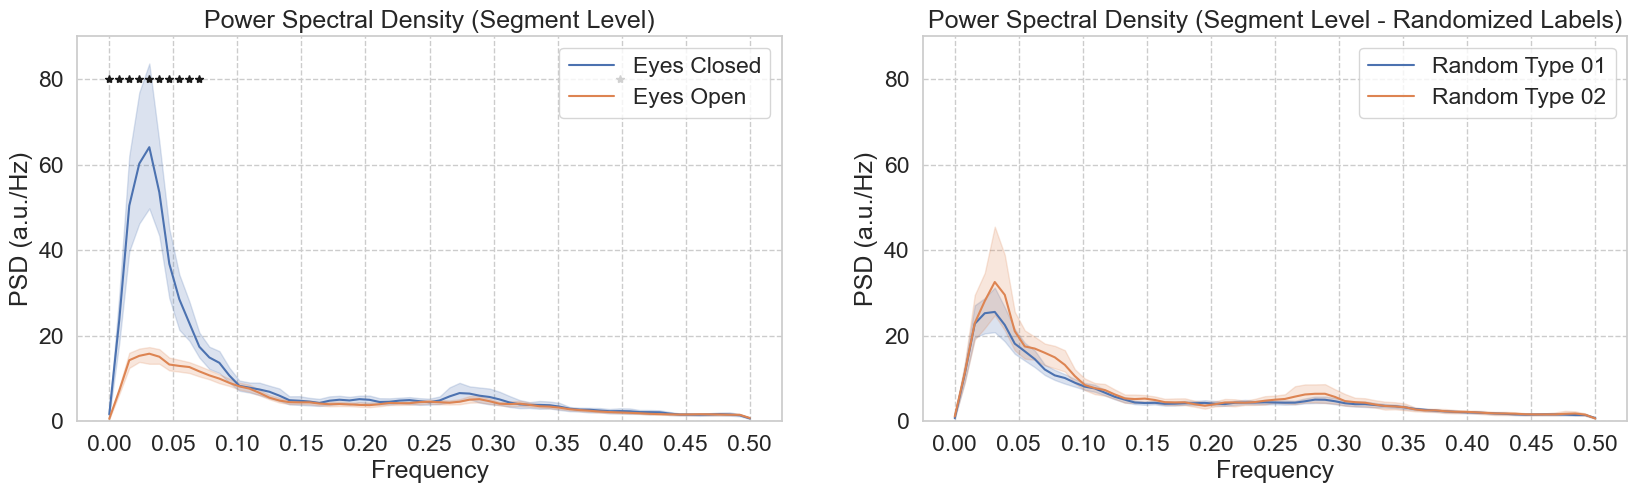

In [16]:
fig

### 6. Save Figures to disk

In [17]:
fig.savefig('./figures/Fig05_PanelB.png')